In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz, simps, cumtrapz

%pylab inline

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


### Расчет

Некоторые константы

In [2]:
Q_EC_76As=0.9233 #in MeV
Z_76As=33

g_a_g_v=1.297 #ratio of vector and axial coupling constants

BS05_OP_pep_ampl=1.42e8
pep_en=1.442 #MeV

S_n = 7.328 #энергия отрыва нейтрона

Функция для расчета порога реакции

In [3]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния в BGT
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [4]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [5]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

In [6]:
def integrate_func(a, b, x, y):
    return np.sum( np.interp(x=np.arange(a, b, 0.001), xp=x, fp=y ) * 0.001 )

### Fermi-function from Numerical Tables for Beta-Decay and Electron Capture

Ферми функия из оцифрованных немецких таблиц. Считываем данные

In [7]:
Fermi_func_new_data = pd.read_excel('../../fermi_func_tables/from_1968/13.xlsx')
Fermi_func_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 14 columns):
P              49 non-null float64
F0L0           49 non-null float64
L0             48 non-null object
1z             48 non-null float64
13             48 non-null float64
ELECTRON
14    48 non-null float64
Z= 33
Izt      48 non-null float64
A= 77          48 non-null float64
A,             48 non-null float64
A2             48 non-null float64
VI2            48 non-null float64
912            48 non-null float64
12             48 non-null float64
Unnamed: 13    48 non-null float64
dtypes: float64(13), object(1)
memory usage: 5.4+ KB


Функция для расчета интерполированного значения. В таблице дана зависимость от импульса вылетающего электрона. Переводим ее в зав-ть от энергии электрона

In [8]:
e_e3 = np.sqrt( np.square( Fermi_func_new_data['P'].values ) + 1 ) #энергия вылетающего электрона
def num_tables_func(x):
    #x in units of mc^2
    return np.interp(x=x, xp=e_e3, fp=Fermi_func_new_data['F0L0'].values )

### B(GT) data

E_x до 5 МэВ!!!

In [9]:
BGT=pd.read_csv('../B(GT) peaks processing//clear_B(GT).csv') #таблица со значениями B(GT)
BGT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
Unnamed: 0        73 non-null int64
Ex                73 non-null float64
Jpi               73 non-null object
diff cross-sec    73 non-null float64
B(GT)             73 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.9+ KB


In [10]:
BGT['B(GT)'] = BGT['B(GT)']/10 #делим на 10 т.к. в таблице все значения домножены на 10

In [11]:
BGT = BGT[ BGT['Jpi'] == '1' ] #отбираем уравни с Jpi == 1

In [12]:
np.sum(BGT['B(GT)'].values)

1.544

### BS05_OP flux

In [13]:
BS05_OP=pd.read_csv('../Vyborov_results/Fluxes/AllFluxes_BS05(OP).csv', sep=';')
BS05_OP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
energy    2000 non-null float64
pp        2000 non-null float64
hep       2000 non-null float64
N         2000 non-null float64
F         2000 non-null float64
O         2000 non-null float64
B         2000 non-null float64
dtypes: float64(7)
memory usage: 109.5 KB


создаем словарь, где ключ - название канала нейтрино (напр O или F), значение - двумерный массив, характеризующий интеполированные значения энергии и амплитуды для даннаго канала нейтрино 

In [14]:
all_fluxes_step = 0.01
Energy_all_fluxes = np.arange(0,20,0.01) #массив характеризующий шаги интегрирования

In [15]:
BS05_OP_dict = {}
for elem in list(BS05_OP.columns)[1:]:
    BS05_OP_dict.update({ elem : 
                        np.interp(x=Energy_all_fluxes, xp=BS05_OP['energy'], 
                                  fp=BS05_OP[elem] ) })

### Cross-section and total rate

### Расчет сечения с учетом только дискретных уровней 

Сечение по Иджири $\sigma_k={(1.597\times10^{-44}\ cm^2)}\epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [16]:
g_a_g_v_square = math.pow(g_a_g_v,2)
m_e_square = math.pow(0.511,2)

In [17]:
#расчет сечения до энергии возбуждения 5 МэВ
def sigma_k_less5(E_nu, E_k, BGT_k, Z, Q_EC):
    #E_k in kev
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=num_tables_func(e_e) #значение ферм-функции при такой энергии
    return m_e_square*e_e*Pi_e*F_col*g_a_g_v_square*BGT_k

In [18]:
#функция расчета свертки сечения с потоком
def rate_calc(sigma):
    
    const = 1.597*math.pow(10,-44)

    sigma_total = np.array(sigma) * const
    
    rate_total = 0
    
    for elem in list(BS05_OP_dict.keys()):
        rate = sum(BS05_OP_dict[elem]*sigma_total*all_fluxes_step) * math.pow(10,36)
        print(elem, ' ', rate)
        rate_total+=rate
        
    sigma_pep = np.interp(pep_en, xp=Energy_all_fluxes, fp=sigma_total)
    rate_pep = BS05_OP_pep_ampl*sigma_pep*math.pow(10,36)
    print('pep', ' ', rate_pep)
    
    rate_total+=rate_pep
    print('rate_total',' ', rate_total)
        
#ВНИМАНИЕ: в расчетах pep не учитывается

    Считаем свертку потока с сечением. 
    BS05_OP_dict[elem] - массив со значениями амплитуды потока нейтрино для канала elem.
    sigma - массив со значениями суммарного сечения.
    all_fluxes_step - шаг интегрирования.
    math.pow(10,36) - для получения итогового значения в SNU. 

In [19]:
sigma_less5=[sum([sigma_k_less5(E_nu, E_k, BGT_k, Z_76As, Q_EC_76As) 
                  for (BGT_k, E_k) in zip(BGT['B(GT)'].values, BGT['Ex'].values)]) 
             for E_nu in Energy_all_fluxes]

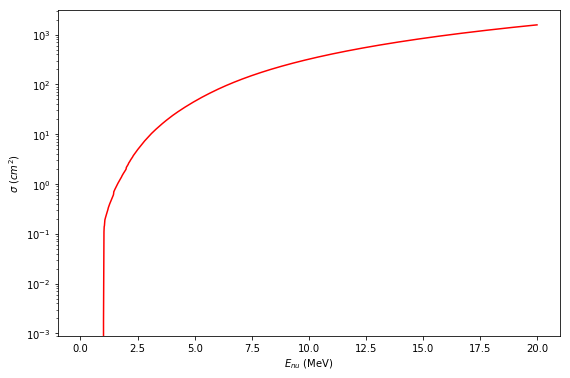

In [20]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_less5, c='r')
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')
#plt.title('Сечение с учетом только дискретных состояний')

In [21]:
rate_calc(sigma_less5)

O   0.827549244941869
B   13.542307922140903
hep   0.04510635720663796
F   0.021059736624544217
pp   0.0
N   0.10198118176409476
pep   1.3685712782859079
rate_total   15.906575720963955


### Расчет сечения с учетом только GTR
GTR в виде гауссовского пика

(0, 6)

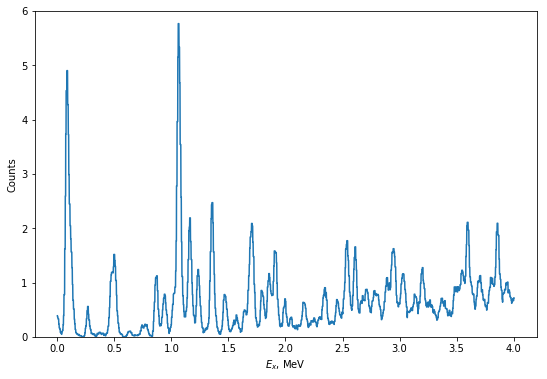

In [22]:
red_0_4 = pd.read_csv('../B(GT) peaks processing/recognition/red data/0_4_red.csv', 
                      sep='\t', decimal=',')

plt.figure(figsize=(9,6))
plt.plot(red_0_4['x'].values, red_0_4['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.ylim(0,6)

(0, 6)

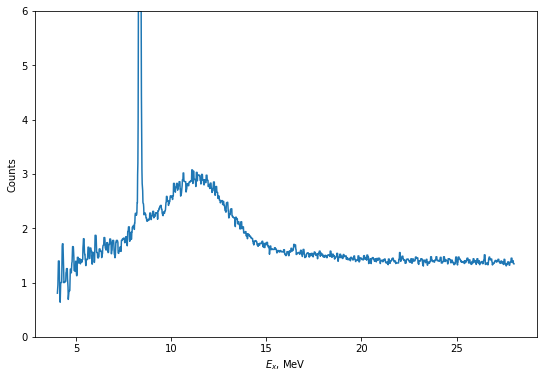

In [23]:
red_4_28 = pd.read_csv('../B(GT) peaks processing/recognition/red data/4_28_red.csv', 
                      sep='\t', decimal=',')

plt.figure(figsize=(9,6))
plt.plot(red_4_28['x'].values, red_4_28['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.ylim(0,6)

In [50]:
def gauss(x, mu, sigma, k):
    y = k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner(x, M, w = 11.3, alpha = 0.018):
    #G = alpha * (w ** 2) + 1
    G = alpha * (w ** 2)
    y = M * G**1 / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов


def breit_vigner2(x, M, w = 11.3, alpha = 0.018):
    G = alpha * (w ** 2) + 1
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner3(x, M, w = 11.3, alpha = 0.018):
    G = alpha * (w ** 2)
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов


In [51]:
mu = 11.3338743
sigma = 2.3
k = 2.90655398

x_norm = np.arange(0, 28, 0.1)
y_norm = gauss(x_norm, mu, sigma, k)

#y_bv = breit_vigner(x_bv, 9.8)
y_bv = breit_vigner(x_norm, 6.8)

y_bv2 = breit_vigner2(x_norm, 9.8)
#y_bv2 = breit_vigner2(x_bv, 6.8)

y_bv3 = breit_vigner3(x_norm, 6.8)

In [52]:
print('gauss', trapz(y_norm, x_norm), '\n',
     'bv1', trapz(y_bv, x_norm), '\n',
     'bv2', trapz(y_bv2, x_norm), '\n')

gauss 16.756991999999997 
 bv1 19.0627235 
 bv2 25.0750965 



In [53]:

gauss = trapz(y_norm[x_norm>14] , x_norm[x_norm>14])
bv1 = trapz(y_bv[x_norm>14], x_norm[x_norm>14])
bv2 = trapz(y_bv2[x_norm>14], x_norm[x_norm>14])

print('gauss', gauss, '\n',
     'bv1', bv1, '\n',
     'bv2', bv2, '\n')

gauss 1.920180499999999 
 bv1 3.738714999999999 
 bv2 6.574272499999999 



(0, 6)

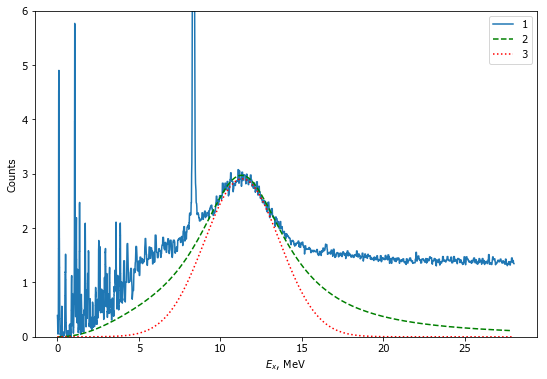

In [54]:
red_0_28 = red_0_4.append(red_4_28)

plt.figure(figsize=(9,6))
plt.plot(red_0_28['x'].values, red_0_28['y'].values, label = '1')
#plt.plot(x_norm, y_bv3, ls='-.', label = '2')
plt.plot(x_norm, y_bv2, c='g', ls='--', label = '2')
plt.plot(x_norm, y_norm, c='r', ls=':', label = '3')
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.legend()
plt.ylim(0,6)
#plt.xlim(0,15)

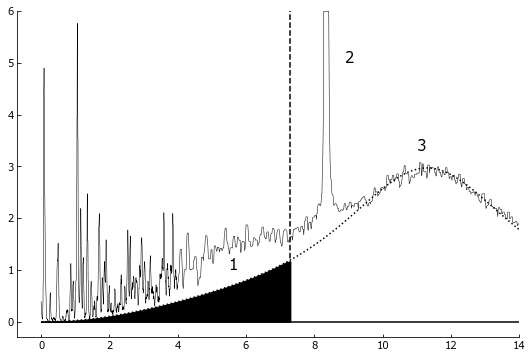

In [55]:
from matplotlib import rc

font = {'family': 'Verdana', 'weight': 'normal'}
rc('font', **font)

#font = {'family': 'Times New Roman', 'weight': 'normal'}
#rc('font', **font)


x1 = red_0_28['x'].values
y1 = red_0_28['y'].values
S_n = 7.3

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(x1, y1, c='black', linewidth=0.5)
ax.plot(x_norm, y_bv2, c='black', ls=':')
ax.vlines(x=S_n, ymin=0, ymax=6, linestyle='dashed')
ax.hlines(0, xmin=0, xmax=20)
ax.text(5.5, 1.0, '1', fontsize=15)
ax.text(8.9, 5, '2', fontsize=15)
ax.text(11, 3.3, '3', fontsize=15)

#plt.xlabel('$E_x$, MeV', horizontalalignment='left')
#plt.ylabel('Т')
ax.margins(x=0.025, y=0.05, tight=False)
ax.set_xlim(xmax=14)
ax.set_ylim(ymax=6)
ax.tick_params(axis='both', which='major', direction='in')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.fill_betweenx(y_bv2, x_norm, S_n, where= x_norm < S_n, color = 'black')

# clears last tick label
#xticks = ax.get_xticks().tolist()
#xticks[-1] = ''
#ax.set_xticklabels(xticks)
#yticks = ax.get_yticks().tolist()
#yticks[-1] = ''
#ax.set_yticklabels(yticks)
# sets axes labels on both ends
#ax.annotate('$\it{E}$, МэВ', xy=(0.95, -0.06), ha='left', va='top', xycoords='axes fraction', fontsize=15)
#ax.annotate('$S(E),$ $МэВ^{-1}$', xy=(-0.05, 1.07), xytext=(-15,2), ha='left', va='top', xycoords='axes fraction', textcoords='offset points', fontsize=15)


#plt.savefig('../../../../../full_spectra5.png', format='png', dpi=600)
#plt.savefig('picture_2.png', format='png', dpi=600)
plt.show()

In [56]:
#функция для отрезки резонансов выше энергии отрыва
def border_func(x_data, y_data, border):
    a=np.where(x_data<border)
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))

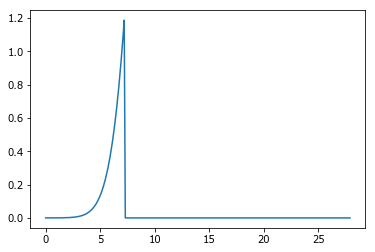

In [57]:
y_bv2_36 = y_bv2 / trapz(y_bv2, x_norm) * (36-1.6)
y_bv2_36 = border_func(x_norm, y_bv2_36, S_n)


y_norm_36 = y_norm / trapz(y_norm, x_norm) * (36-1.6)
y_norm_36 = border_func(x_norm, y_norm_36, S_n)
plt.plot(x_norm, y_norm_36)

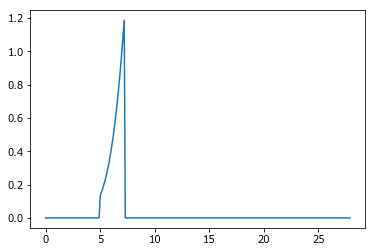

In [58]:
y_norm_36_5_Sn = y_norm_36 - border_func(x_norm, y_norm_36, 5)

plt.plot(x_norm, y_norm_36_5_Sn)

Сечение для непрерывной части

$\sigma = {(1.597\times10^{-44}\ cm^2)} \int^{z-Q}_{0} {(\frac{g_a}{g_v})^2 \cdot \sqrt{(z-Q-x+0.511)^2-0.511^2} \cdot (z-Q-x+0.511) \cdot S_{GTR}(x) \cdot F(z-Q-x+0.511)} dx $ 


In [59]:
#введем новую переменную p = z - Q
def sigma_k_GTR(x, p, x_data, y_data):
    e_energy = p - x + 0.511
    return g_a_g_v_square*np.sqrt(e_energy**2-m_e_square)*e_energy*np.interp(x,xp=x_data,fp=y_data)*num_tables_func(e_energy/0.511) 


In [60]:
#разбиваем интервал интегрирования на субинтервалы
def intervals(a,b,n):
    c=np.linspace(a,b,num=n)
    return [[c[i], c[i+1]] for i in range(len(c)-1)]

In [61]:
#считаем сечение
def cross_sec(a,b, sigma_func, shape_x, shape_y, int_num=50):
    borders_list = intervals(a,b, int_num)
    #return sum([quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    return sum([sc.integrate.fixed_quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    #return sum([sc.integrate.romberg(sigma_func, i[0],i[1], args=(b,shape_x, shape_y)) for i in borders_list])

In [67]:
p_list = np.arange(0,20, 0.1) #p = z - Q

#sigma_more5_temp = [ quad(sigma_k_more5, 0, p, args=(p), limit=200)[0] for p in p_list]
#sigma_more5_temp = [ sc.integrate.fixed_quad(sigma_k_more5, 0, p, args=(p, x_norm, y_norm), n=20)[0] for p in p_list]
#sigma_more5_temp = [ sc.integrate.romberg(sigma_k_more5, 0, p, args=(p,)) for p in p_list]
#sigma_more5_temp = [sigma_more5_ab(p) for p in p_list]

sigma_GTR_temp = [cross_sec(0,p, sigma_k_GTR, x_norm, y_bv2_36_5_Sn, 200) for p in p_list]

sigma_GTR = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_GTR_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

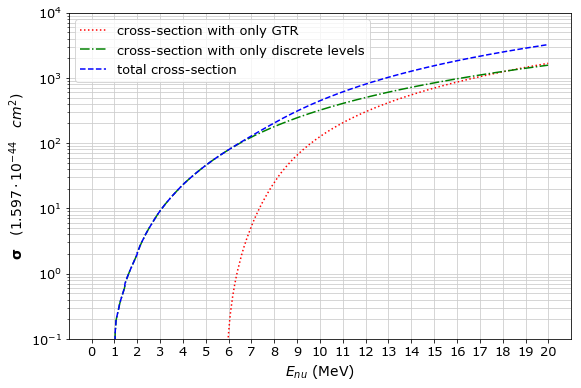

In [68]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_GTR, ls=':', c='r', label='cross-section with only GTR')
plt.plot(Energy_all_fluxes, sigma_less5, ls='-.', c='g', label='cross-section with only discrete levels')
plt.plot(Energy_all_fluxes, sigma_less5+sigma_GTR, ls='--', c='b', label='total cross-section')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad (1.597 \cdot 10^{-44} \quad cm^2)$', fontsize=14)
plt.yscale('log')
plt.legend(fontsize=13)
plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-1), 10**(4))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_sections.png', format='png', dpi=500)

In [69]:
rate_calc(sigma_less5)

O   0.827549244941869
B   13.542307922140903
hep   0.04510635720663796
F   0.021059736624544217
pp   0.0
N   0.10198118176409476
pep   1.3685712782859079
rate_total   15.906575720963955


In [70]:
rate_calc(sigma_GTR)

O   0.0
B   4.068567392791599
hep   0.02728254767093889
F   0.0
pp   0.0
N   0.0
pep   0.0
rate_total   4.095849940462538


In [71]:
rate_calc(sigma_less5+sigma_GTR)

O   0.827549244941869
B   17.610875314932503
hep   0.07238890487757686
F   0.021059736624544217
pp   0.0
N   0.10198118176409476
pep   1.3685712782859079
rate_total   20.0024256614265


In [41]:
sigma_GTR_temp_5_Sn = [cross_sec(0,p, sigma_k_GTR, x_norm, y_bv2_36_5_Sn, 200) for p in p_list]
sigma_GTR_5_Sn = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_GTR_temp_5_Sn)

rate_calc(sigma_GTR_5_Sn)

N   0.0
B   4.068567392791599
hep   0.02728254767093889
F   0.0
O   0.0
pp   0.0
pep   0.0
rate_total   4.095849940462538


In [42]:
rate_calc(sigma_less5+sigma_GTR_5_Sn)

N   0.10198118176409476
B   17.610875314932503
hep   0.07238890487757686
F   0.021059736624544217
O   0.827549244941869
pp   0.0
pep   1.3685712782859079
rate_total   20.0024256614265


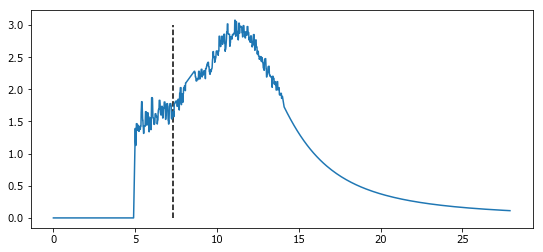

In [43]:
GTR = pd.DataFrame( np.array([x_norm, y_bv2]).T, columns=['x', 'y'])
temp_pd = pd.DataFrame( np.array([x_norm, np.zeros(x_norm.shape)]).T, columns=['x', 'y'])

#data2 = GTR[ GTR['x']<5 ].append( red_0_28[ (red_0_28['x']>5) & (red_0_28['x']<8.1)] )
data2 = temp_pd[ temp_pd['x']<5 ].append( red_0_28[ (red_0_28['x']>5) & (red_0_28['x']<8.1)] )
data2 = data2.append(red_0_28[ (red_0_28['x']>8.6) & (red_0_28['x']<14)])
data2 = data2.append( GTR[ GTR['x']>14 ] )

plt.figure(figsize=(9,4))
plt.plot( data2['x'].values, data2['y'].values)
plt.vlines(x=S_n, ymin=0, ymax=3, linestyle='dashed')
#plt.plot( GTR['x'].values, GTR['y'].values, ls = '--')

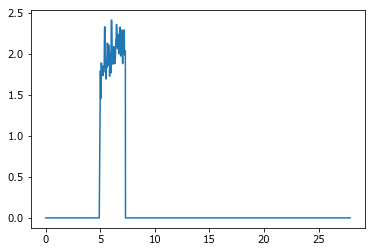

In [44]:
y_data2 = data2['y'].values
x_data2 = data2['x'].values

y_data2 = y_data2 / trapz(y_data2, x_data2) * (36-1.6)
y_data2 = border_func(x_data2, y_data2, S_n)
plt.plot(x_data2, y_data2)

In [45]:
sigma_GTR_temp_data2 = [cross_sec(0,p, sigma_k_GTR, x_data2, y_data2, 200) for p in p_list]
sigma_GTR_data2 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_GTR_temp_data2)

rate_calc(sigma_GTR_data2)

N   0.0
B   7.629866531310546
hep   0.05022527471043527
F   0.0
O   0.0
pp   0.0
pep   0.0
rate_total   7.680091806020981


In [46]:
rate_calc(sigma_less5+sigma_GTR_data2)

N   0.10198118176409476
B   21.172174453451454
hep   0.09533163191707324
F   0.021059736624544217
O   0.827549244941869
pp   0.0
pep   1.3685712782859079
rate_total   23.586667526984947


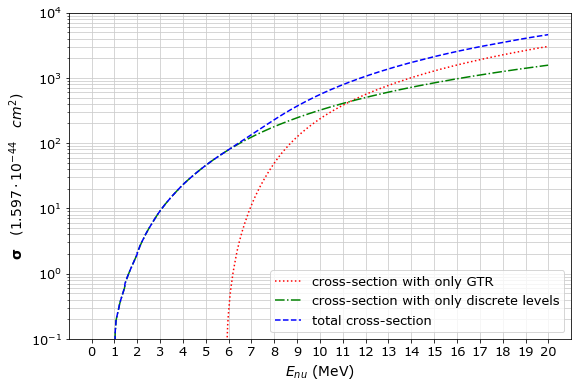

In [47]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_GTR_data2, ls=':', c='r', label='cross-section with only GTR')
plt.plot(Energy_all_fluxes, sigma_less5, ls='-.', c='g', label='cross-section with only discrete levels')
plt.plot(Energy_all_fluxes, sigma_less5+sigma_GTR_data2, ls='--', c='b', label='total cross-section')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad (1.597 \cdot 10^{-44} \quad cm^2)$', fontsize=14)
plt.yscale('log')
plt.legend(fontsize=13)
plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-1), 10**(4))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)

In [48]:
#y_bv2 = breit_vigner2(x_norm, 9.8)
temp_pd4 = pd.DataFrame( np.array([data2['x'].values, 
                                   breit_vigner2(data2['x'].values, 12.8)]).T, columns=['x','y'])
temp_pd4 = temp_pd2[temp_pd2['x']<5].append(temp_pd4[temp_pd4['x']>5])

plt.figure(figsize=(9,4))
plt.plot(data2['x'].values, data2['y'].values / trapz(data2['y'].values, data2['x'].values) * (36-1.6))
plt.plot(temp_pd4['x'].values, temp_pd4['y'].values, ls='--')
plt.vlines(x=S_n, ymin=0, ymax=4, linestyle='dashed')
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')

print(trapz(temp_pd4['y'].values, temp_pd4['x'].values), 
      trapz(temp_pd4['y'].values, temp_pd4['x'].values)/(36-1.6))

NameError: name 'temp_pd2' is not defined

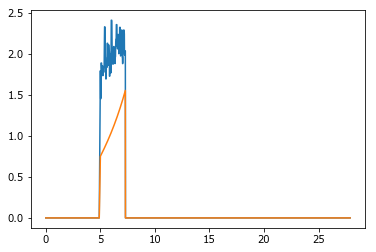

In [49]:
temp_pd2 = pd.DataFrame( np.array([x_norm, np.zeros(x_norm.shape)]).T, columns=['x', 'y'])
temp_pd3 = pd.DataFrame( np.array([data2['x'].values, 
                                   breit_vigner2(data2['x'].values, 12.8)]).T, columns=['x','y'])

data3 = temp_pd2[temp_pd2['x']<5].append(temp_pd3[(temp_pd3['x']>5) & (temp_pd3['x']<S_n)])
data3 = data3.append(temp_pd2[temp_pd2['x']>S_n])

plt.plot(x_data2, y_data2)
plt.plot(data3['x'].values,data3['y'].values)

In [50]:
sigma_GTR_temp_data3 = [cross_sec(0,p, sigma_k_GTR, data3['x'].values,data3['y'].values, 200) for p in p_list]
sigma_GTR_data3 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_GTR_temp_data3)

rate_calc(sigma_GTR_data3)

N   0.0
B   3.924249993534193
hep   0.026463281066995945
F   0.0
O   0.0
pp   0.0
pep   0.0
rate_total   3.950713274601189


In [51]:
rate_calc(sigma_less5+sigma_GTR_data3)

N   0.10198118176409476
B   17.466557915675097
hep   0.07156963827363391
F   0.021059736624544217
O   0.827549244941869
pp   0.0
pep   1.3685712782859079
rate_total   19.85728899556515


In [53]:
out_array = np.array([Energy_all_fluxes, sigma_less5, sigma_GTR_data3, sigma_GTR_data2]).T
out = pd.DataFrame(out_array , columns=['E', 'sigma diskret', 'sigma Breit vigner', 'sigma continious'])
out.to_excel('cross_sections.xlsx')

### Расчет сечения с учетом только IAS
IAS в виде гауссовского пика, параметры взяты из декомпозиции

In [232]:
m_IAS = 8.31025152e+00
s_IAS = -1.41850172e-02
k_IAS = 2.73399015e+01

x_IAS = np.arange(6, 9, 0.001)
y_IAS = gauss(x_IAS, m_IAS, s_IAS, k_IAS)

plt.plot(x_IAS, y_IAS)
plt.xlim(8,9)
trapz(y_IAS, x_IAS)

TypeError: 'numpy.float64' object is not callable

IAS
(N-Z) = 12. Нормируем 

In [35]:
y_IAS = y_IAS/trapz(y_IAS, x_IAS)*12
trapz(y_IAS, x_IAS)

12.0

(0, 5)

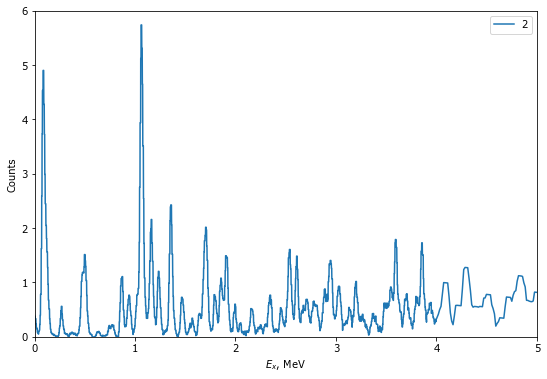

In [227]:
plt.figure(figsize=(9,6))
#plt.plot(a['x'].values, a['y'].values, label = '1')
plt.plot(red_0_28['x'].values, red_0_28['y'].values - breit_vigner2(red_0_28['x'].values, 9.8),
         label = '2')
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.legend()
plt.ylim(0,6)
plt.xlim(0,5)

In [228]:
red_0_28['x'].values

array([  1.89498540e-03,   3.24636760e-03,   4.59035370e-03, ...,
         2.79902735e+01,   2.80035756e+01,   2.80168776e+01])

(0, 5)

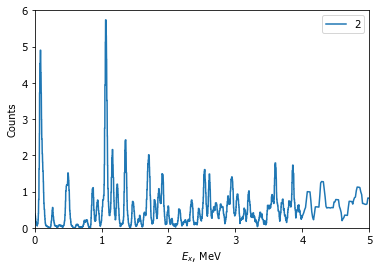

In [229]:
X_0_5_corr = red_0_28['x'].values[ red_0_28['x'].values < 5 ]
Y_0_5_corr = red_0_28['y'].values - breit_vigner2(red_0_28['x'].values, 9.8)
Y_0_5_corr = Y_0_5_corr[ red_0_28['x'].values < 5 ]

plt.plot(X_0_5_corr, Y_0_5_corr, label = '2')
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.legend()
plt.ylim(0,6)
plt.xlim(0,5)

In [230]:
trapz(Y_0_5_corr, X_0_5_corr)

2.8804882788213626